# Time Series Analysis with LSTM using Python's Keras Library
* Ref: https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
* Data: From Yahoo Finance download Apple stock price
  * Train: 2013-01-01 to 2017-12-31
  * Test: 2018-01-01 to 2018-12-31

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/AAPL.csv',
                 index_col=0,
                 parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,79.117142,79.285713,77.375717,78.432854,69.057251,140129500
2013-01-03,78.268570,78.524284,77.285713,77.442856,68.185600,88241300
2013-01-04,76.709999,76.947144,75.118568,75.285713,66.286301,148583400
2013-01-07,74.571426,75.614288,73.599998,74.842857,65.896370,121039100
2013-01-08,75.601425,75.984283,74.464287,75.044289,66.073723,114676800


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2013-01-02 to 2018-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.6 KB


* Index 必須是 DatetimeIndex
* 畫圖看分佈，只看 `Open` 欄位就好

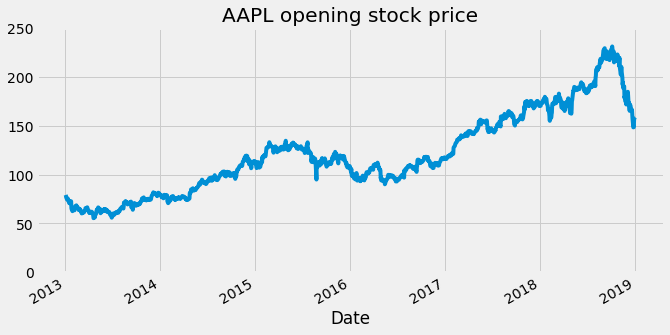

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
df['Open'].plot(ax=ax)
plt.ylim(0, 250)
plt.title("AAPL opening stock price")
plt.show()

* 因為只要預測 `Open` 的股價，所以只選擇這個欄位

In [ ]:
df = df.loc[:, ["Open"]]
df.head()

,Open
Date,
2013-01-02,79.117142
2013-01-03,78.268570
2013-01-04,76.709999
2013-01-07,74.571426
2013-01-08,75.601425


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2013-01-02 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [ ]:
df.tail()

,Open
Date,
2018-12-24,148.149994
2018-12-26,148.300003
2018-12-27,155.839996
2018-12-28,157.500000
2018-12-31,158.529999


## 2. Preprocessing data

### 2.1 Train test split

* 2018-01-01 之前的當作 training_set
* 2018-01-01 之後的當作 testing_set

In [ ]:
training_set = df.loc[:'2018-01-01', 'Open']
testing_set = df.loc['2018-01-01':, 'Open']

print(len(training_set), type(training_set), training_set.shape)
print(training_set[:5], training_set[-5:])

print(len(testing_set), type(testing_set), testing_set.shape)
print(testing_set[:5], testing_set[-5:])

1259 <class 'pandas.core.series.Series'> (1259,)
Date
2013-01-02    79.117142
2013-01-03    78.268570
2013-01-04    76.709999
2013-01-07    74.571426
2013-01-08    75.601425
Name: Open, dtype: float64 Date
2017-12-22    174.679993
2017-12-26    170.800003
2017-12-27    170.100006
2017-12-28    171.000000
2017-12-29    170.520004
Name: Open, dtype: float64
251 <class 'pandas.core.series.Series'> (251,)
Date
2018-01-02    170.160004
2018-01-03    172.529999
2018-01-04    172.539993
2018-01-05    173.440002
2018-01-08    174.350006
Name: Open, dtype: float64 Date
2018-12-24    148.149994
2018-12-26    148.300003
2018-12-27    155.839996
2018-12-28    157.500000
2018-12-31    158.529999
Name: Open, dtype: float64


### 2.2 Normalization

* **Whenever you use a neural network, you should normalize or scale your data.**
* 注意放到 `fit_transform()` 的必須要是一個 2-dim array
* **不可以用整個 dataset 來做 scaling，因為不能使用到 test sample 的資訊**
  * 用 training_set 來做 `fit_transform()`
  * testing_set 只能使用 `transform()`

In [ ]:
print(training_set.shape, testing_set.shape)

(1259,) (251,)


* training_set 和 testing_set 兩個都是 1-d array 所以要 reshape 成 2-d array 這樣 MinMaxScaler 才能吃
* training_set 和 testing_set 兩個都是 series，所以沒有 `reshape()`，要變成 series.values 才能 reshpae

In [ ]:
reshaped_training_set = training_set.values.reshape(-1, 1)
reshaped_testing_set = testing_set.values.reshape(-1, 1)
print(reshaped_training_set.shape, reshaped_testing_set.shape)
print(reshaped_training_set[:5], reshaped_testing_set[:5])

(1259, 1) (251, 1)
[[79.117142]
 [78.26857 ]
 [76.709999]
 [74.571426]
 [75.601425]] [[170.160004]
 [172.529999]
 [172.539993]
 [173.440002]
 [174.350006]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) # normalize data between 0 and 1
scaled_training_set = scaler.fit_transform(reshaped_training_set)
print(scaled_training_set[:5])

scaled_testing_set = scaler.transform(reshaped_testing_set) # 並不會使用到 scaled_testing_set，但是這邊做 scale 這樣才能知道之後用新的 testing_set 做 scale 的結果對不對
print(scaled_testing_set[:5])

[[0.19795893]
 [0.19086893]
 [0.17784673]
 [0.15997849]
 [0.16858435]]
[[0.95864171]
 [0.97844353]
 [0.97852703]
 [0.9860468 ]
 [0.99365008]]


### 2.3 改成 LSTM 吃的格式
* LSTM input must be **3-dim**: **(number of records, number of timesteps, number of indicators)**
    * number of records = number of rows
    * number of indicators = number of features
* 如果今天是 $T$ 且 time_steps = $N$，那我們要用 $T - N$ 到 $T - 1$ 的資料來預測 $T$ 的結果
  * 這邊用 time_steps=60 來做預測
* `X_train` 和 `y_train` 要先變成這樣的格式: 
  * `X_train` = [data[0:60], data[1:61], data[2:62], ..., data[i, i+60], ...]
  * `y_train` = [data[61], data[62], ..., data[i+61], ...]
  * `X_train` 的元素就是每 60 個一組 `y_train` 的元素就是從第 61 天開始的值
  * 然後再把 `X_train` 從 2-d 改成 3-d array

In [ ]:
time_steps = 60
length = len(scaled_training_set)

X_train = []
y_train = []

for i in range(time_steps, length):
  X_train.append(scaled_training_set[i - time_steps : i, 0]) # 因為 scaled_training_set 是 2-d array，要取得每一列的元素的數值要用 [row, 0]
  y_train.append(scaled_training_set[i, 0])

print(len(X_train), type(X_train))
print(X_train[:3])
print(len(y_train), type(y_train))
print(y_train[:3])

1199 <class 'list'>
[array([0.19795893, 0.19086893, 0.17784673, 0.15997849, 0.16858435,
       0.16057534, 0.16779659, 0.15878493, 0.13691814, 0.13169014,
       0.12732155, 0.1460253 , 0.13195271, 0.1391621 , 0.14423488,
       0.08597518, 0.07605635, 0.059513  , 0.08418477, 0.08239435,
       0.08237052, 0.08491287, 0.07870612, 0.06693722, 0.08176175,
       0.0898544 , 0.10268561, 0.10566959, 0.10926234, 0.09458105,
       0.09137026, 0.09653853, 0.08728814, 0.08321794, 0.06926475,
       0.07314397, 0.07863453, 0.0666627 , 0.07216522, 0.06693722,
       0.05971593, 0.04754117, 0.03999762, 0.05555025, 0.04360229,
       0.0499284 , 0.0498687 , 0.05685129, 0.04831701, 0.05354501,
       0.05963236, 0.06383384, 0.08537839, 0.08289565, 0.07430177,
       0.07950586, 0.09157316, 0.0924684 , 0.08174982, 0.07382432]), array([0.19086893, 0.17784673, 0.15997849, 0.16858435, 0.16057534,
       0.16779659, 0.15878493, 0.13691814, 0.13169014, 0.12732155,
       0.1460253 , 0.13195271, 0.139162

In [ ]:
# 要把 X_train 和 y_train 從 list 變成 numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)
print(len(X_train), type(X_train), X_train.shape)
print(X_train[:3])
print(len(y_train), type(y_train), y_train.shape)
print(y_train[:3])

1199 <class 'numpy.ndarray'> (1199, 60)
[[0.19795893 0.19086893 0.17784673 0.15997849 0.16858435 0.16057534
  0.16779659 0.15878493 0.13691814 0.13169014 0.12732155 0.1460253
  0.13195271 0.1391621  0.14423488 0.08597518 0.07605635 0.059513
  0.08418477 0.08239435 0.08237052 0.08491287 0.07870612 0.06693722
  0.08176175 0.0898544  0.10268561 0.10566959 0.10926234 0.09458105
  0.09137026 0.09653853 0.08728814 0.08321794 0.06926475 0.07314397
  0.07863453 0.0666627  0.07216522 0.06693722 0.05971593 0.04754117
  0.03999762 0.05555025 0.04360229 0.0499284  0.0498687  0.05685129
  0.04831701 0.05354501 0.05963236 0.06383384 0.08537839 0.08289565
  0.07430177 0.07950586 0.09157316 0.0924684  0.08174982 0.07382432]
 [0.19086893 0.17784673 0.15997849 0.16858435 0.16057534 0.16779659
  0.15878493 0.13691814 0.13169014 0.12732155 0.1460253  0.13195271
  0.1391621  0.14423488 0.08597518 0.07605635 0.059513   0.08418477
  0.08239435 0.08237052 0.08491287 0.07870612 0.06693722 0.08176175
  0.089854

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(len(X_train), type(X_train), X_train.shape)
print(X_train[:3])

1199 <class 'numpy.ndarray'> (1199, 60, 1)
[[[0.19795893]
  [0.19086893]
  [0.17784673]
  [0.15997849]
  [0.16858435]
  [0.16057534]
  [0.16779659]
  [0.15878493]
  [0.13691814]
  [0.13169014]
  [0.12732155]
  [0.1460253 ]
  [0.13195271]
  [0.1391621 ]
  [0.14423488]
  [0.08597518]
  [0.07605635]
  [0.059513  ]
  [0.08418477]
  [0.08239435]
  [0.08237052]
  [0.08491287]
  [0.07870612]
  [0.06693722]
  [0.08176175]
  [0.0898544 ]
  [0.10268561]
  [0.10566959]
  [0.10926234]
  [0.09458105]
  [0.09137026]
  [0.09653853]
  [0.08728814]
  [0.08321794]
  [0.06926475]
  [0.07314397]
  [0.07863453]
  [0.0666627 ]
  [0.07216522]
  [0.06693722]
  [0.05971593]
  [0.04754117]
  [0.03999762]
  [0.05555025]
  [0.04360229]
  [0.0499284 ]
  [0.0498687 ]
  [0.05685129]
  [0.04831701]
  [0.05354501]
  [0.05963236]
  [0.06383384]
  [0.08537839]
  [0.08289565]
  [0.07430177]
  [0.07950586]
  [0.09157316]
  [0.0924684 ]
  [0.08174982]
  [0.07382432]]

 [[0.19086893]
  [0.17784673]
  [0.15997849]
  [0.16858


* testing_set 也要改成 LSTM 吃的格式
* 但是 testing_set 的第一個數，必須要從 training_set 的倒數 time_steps=60 個數來預測，所以不能直接使用剛剛的 testing_set，要重新處理
* 新的 testing_set 的元素數目 = time_steps 的數目 + 舊的 testing_set 的元素數目
* 新的 testing_set 也要做 scale

In [ ]:
len(testing_set)

251

In [ ]:
start_index = len(df) - len(testing_set) - time_steps
start_index

1199

In [ ]:
new_testing_set = df.iloc[start_index:]['Open'].values
scaled_new_testing_set = scaler.transform(new_testing_set.reshape(-1, 1))
print(len(scaled_new_testing_set), type(scaled_new_testing_set), scaled_new_testing_set.shape)
print(scaled_new_testing_set[60:65]) # 在新的 testing_set 中 index = 60 ~ 64 才是舊的 testing_set 中的前五個，拿這五個來和舊的比較

311 <class 'numpy.ndarray'> (311, 1)
[[0.95864171]
 [0.97844353]
 [0.97852703]
 [0.9860468 ]
 [0.99365008]]


In [ ]:
print(scaled_testing_set[:5])

[[0.95864171]
 [0.97844353]
 [0.97852703]
 [0.9860468 ]
 [0.99365008]]


* 和舊的結果相同，表示我沒有做錯
* 而且 251 + 60 = 311 正好符合 scaled_new_testing_set 的長度
* 接下來要把 scaled_new_testing_set 改成 LSTM 吃的格式

In [ ]:
X_test = []

for i in range(time_steps, len(scaled_new_testing_set)):
  X_test.append(scaled_new_testing_set[i - time_steps : i, 0])
print(len(X_test), type(X_test)) # 預計經過這個步驟後，X_test 的長度會和 testing_set 一樣是 251 個
print(X_test[:3]) # 目前 X_test 仍然不是 LSTM 要的格式

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 這時候才變成 LSTM 需要的格式
print(len(X_test), type(X_test), X_test.shape)

251 <class 'list'>
[array([0.82512526, 0.83172595, 0.83874431, 0.84083311, 0.84008117,
       0.84325619, 0.84643109, 0.85620667, 0.87191452, 0.87726185,
       0.84659823, 0.8454285 , 0.84776795, 0.84275477, 0.84793509,
       0.8506087 , 0.86782042, 0.90625446, 0.93975883, 0.95621862,
       0.92889715, 0.9907257 , 0.97710666, 0.98997377, 0.99624018,
       1.        , 1.        , 0.98654809, 0.98270464, 0.95705419,
       0.96716393, 0.9659942 , 0.95972779, 0.9638219 , 0.98537837,
       0.99991649, 0.9994987 , 0.99323229, 0.9792791 , 0.96089752,
       0.95688705, 0.97802574, 0.94945092, 0.9364168 , 0.94920027,
       0.96139894, 0.95062064, 0.9752685 , 0.97819288, 0.97735731,
       0.98763431, 0.99807833, 0.99933157, 0.9979947 , 0.99214607,
       0.99640719, 0.96398904, 0.95814041, 0.96566005, 0.96164958]), array([0.83172595, 0.83874431, 0.84083311, 0.84008117, 0.84325619,
       0.84643109, 0.85620667, 0.87191452, 0.87726185, 0.84659823,
       0.8454285 , 0.84776795, 0.8427547

## 3. Build LSTM model
* 蓋一個 $h_{t-1}= 50$，共 4 層 LSTM layers，最後輸出一個數的 LSTM model
  * 一層就表示一個 LSTM cell 
* 用 MSE loss
* 用 Adam stochastic gradient descent optimizer
* LSTM 參數數目計算
  * 4 * lstm_hidden_state_size * (lstm_inputs_size + bias_variable + lstm_outputs_size) 
    * 但是因為 LSTM 的特性: lstm_hidden_state_size = lstm_outputs_size = num_units
  * 公式就可以寫成 num_params = [(num_units + input_dim + 1) * num_units] * 4
    * num_units + input_dim: concat [h(t-1), x(t)]
* 輸入層: [50 + 1 (why?) + 1 bias] * 這一層有 50 個 unit * 4 個 gate
* 1st hidden layer: [50 (前一層的輸出 $h_{t-1}$) + 50 (這一層有多少 unit) + 1 (bias)] * 50 (這一層有多少 unit) * 4 (4 個 gate) = 20200
* 2nd hidden layer: [50 + 50 + 1] * 50 * 4 = 20200
* 3nd hidden layer: [50 + 50 + 1] * 50 * 4 = 20200
* Dense layer: 50 * 1 + 1 = 51
共 10400 + 20200 * 3 + 51 = 71051 個參數


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
model = Sequential()

# units: referring to the dimensionality of the hidden state and dimensionality of the output state
# return_sequences: 要不要加上其他 LSTM layer?
# input_shape=(number of timesteps, number of indicators) 只有第一層才要指定 input_shape
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2)) # Use Dropout layer to avoid overfitting

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50)) # 沒有要加上其他 LSTM layer 了，所以沒有 return_sequences 參數
model.add(Dropout(0.2))

model.add(Dense(units = 1)) # 最後加上一層 Dense layer，只有一個 neuron 因為只要求出單一的一個數值

model.compile(optimizer="adam", loss="mean_squared_error") # 前面都只是告訴 keras 要怎麼建 LSTM model，這邊才是真正的建立 LSTM model

In [ ]:
model.summary() # 看 model 的結構

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

* Fit model



In [ ]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 4s 105ms/step - loss: 0.0302
Epoch 2/100
38/38 [==============================] - 4s 106ms/step - loss: 0.0049
Epoch 3/100
38/38 [==============================] - 4s 103ms/step - loss: 0.0050
Epoch 4/100
38/38 [==============================] - 4s 106ms/step - loss: 0.0044
Epoch 5/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0035
Epoch 6/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0049
Epoch 7/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0056
Epoch 8/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0038
Epoch 9/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0036
Epoch 10/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0036
Epoch 11/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0035
Epoch 12/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0035
Epoch 13/100


## 4. Forecast

In [ ]:
predictions = model.predict(X_test)
print(len(predictions), type(predictions), predictions.shape)
print(predictions[:5])

251 <class 'numpy.ndarray'> (251, 1)
[[0.9404598 ]
 [0.9383638 ]
 [0.94193757]
 [0.948952  ]
 [0.95701426]]


* 因為 X_test 是已經 scale 過後的，所以預測的結果也是 scale 的，要把這個反轉回 scale 之前的才行

In [ ]:
predictions = scaler.inverse_transform(predictions)
print(len(predictions), type(predictions), predictions.shape)
print(predictions[:5])

251 <class 'numpy.ndarray'> (251, 1)
[[167.98389]
 [167.73302]
 [168.16075]
 [169.00029]
 [169.96523]]


* 最後畫圖比較結果

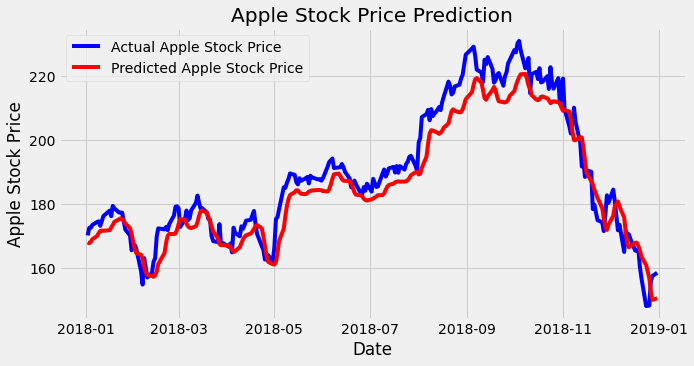

In [ ]:
# 因為 predictions 是 (251, 1) 的 2-d array 要畫圖時要先改成 1-d array
# 然後 X 軸要和 testing_set 一樣
plt.figure(figsize=(10, 5))
plt.plot(testing_set, color='blue', label='Actual Apple Stock Price')
plt.plot(testing_set.index, predictions.flatten() , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## 5. Fitting with GPU
* Do I have GPU?
* Does Keras version support GPU?
    * keras >= 2.1.1 supports GPU

In [ ]:
# Check GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13164394223380881056
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4543544834013165565
physical_device_desc: "device: XLA_CPU device"
]


In [ ]:
# Check Keras version
import keras
print(keras.__version__)

2.4.3


I have GPU on this machine and the Keras version supports GPU

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: ignored

In [ ]:
# import tensorflow as tf
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
# # sess = tf.Session(config=config) 
# keras.backend.set_session(sess)